In [1]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from utils import *
from process import *
import train_model
from datetime import datetime

In [ ]:
section_id="151672"
k=7

In [20]:
im_re = pd.read_csv(os.path.join('../Data/DLPFC/',section_id, "image_representation/ViT_pca_representation.csv"),
                    header=0, index_col=0,sep=',')
print(section_id, k)

input_dir = os.path.join('../Data/DLPFC/', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')

adata.var_names_make_unique()
prefilter_genes(adata, min_cells=3)  # avoiding all genes are zeros
# prefilter_specialgenes(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

adata.obsm["im_re"] = im_re
adata =  adata[:, adata.var['highly_variable']]

Ann_df = pd.read_csv(os.path.join('../Data/DLPFC/',
                                  section_id, "cluster_labels_" + section_id + '.csv'), sep=',', header=0, index_col=0)
adata.obs['ground_truth'] = Ann_df.loc[adata.obs_names, 'ground_truth']
Ann_df = Ann_df.replace(1, "Layer 1")
Ann_df = Ann_df.replace(2, "Layer 2")
Ann_df = Ann_df.replace(3, "Layer 3")
Ann_df = Ann_df.replace(4, "Layer 4")
Ann_df = Ann_df.replace(5, "Layer 5")
Ann_df = Ann_df.replace(6, "Layer 6")
Ann_df = Ann_df.replace(7, "WM")
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'ground_truth']

151670 7


In [21]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()


In [23]:
adata.obsm["adj"] = calculate_adj_matrix(adata)
adata = train_model.train(adata, k, h=[1500,750,70], n_epochs=200, enhancement=True, dim_sub=70//7, heads=5)

Initialize D
Initialization of D Finished
[2025-10-28 15:09:27] Epoch: 0/200, Loss: 12.7878
[2025-10-28 15:09:34] Epoch: 5/200, Loss: 12.7330
[2025-10-28 15:09:38] Epoch: 10/200, Loss: 12.6454
[2025-10-28 15:09:43] Epoch: 15/200, Loss: 12.5871
[2025-10-28 15:09:47] Epoch: 20/200, Loss: 12.5306
[2025-10-28 15:09:51] Epoch: 25/200, Loss: 12.4771
[2025-10-28 15:09:56] Epoch: 30/200, Loss: 12.4235
[2025-10-28 15:10:01] Epoch: 35/200, Loss: 12.3673
[2025-10-28 15:10:05] Epoch: 40/200, Loss: 12.3091
[2025-10-28 15:10:10] Epoch: 45/200, Loss: 12.2486
[2025-10-28 15:10:15] Epoch: 50/200, Loss: 12.1857
[2025-10-28 15:10:19] Epoch: 55/200, Loss: 12.1202
[2025-10-28 15:10:24] Epoch: 60/200, Loss: 12.0535
[2025-10-28 15:10:30] Epoch: 65/200, Loss: 11.9856
[2025-10-28 15:10:34] Epoch: 70/200, Loss: 11.9163
[2025-10-28 15:10:39] Epoch: 75/200, Loss: 11.8445
[2025-10-28 15:10:44] Epoch: 80/200, Loss: 11.7654
[2025-10-28 15:10:49] Epoch: 85/200, Loss: 11.6468
[2025-10-28 15:10:54] Epoch: 90/200, Loss:

Adjusted rand index = 0.71


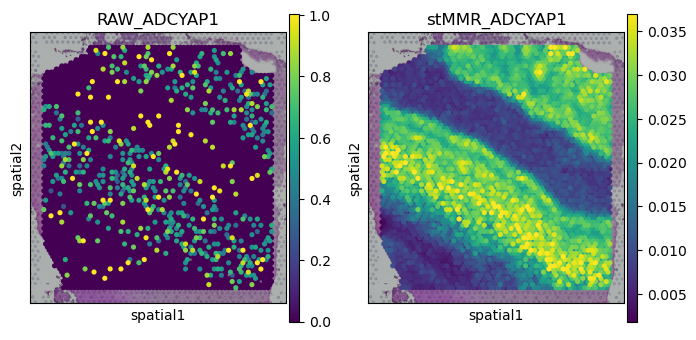

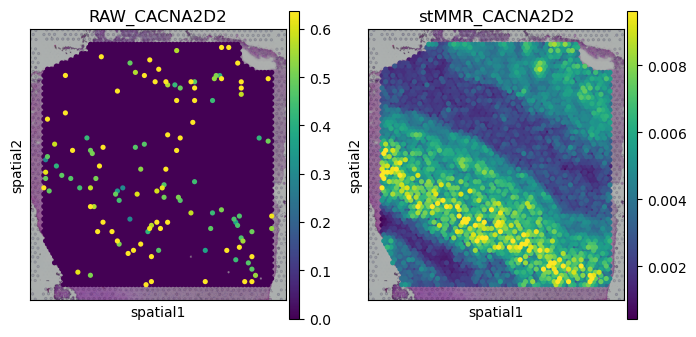

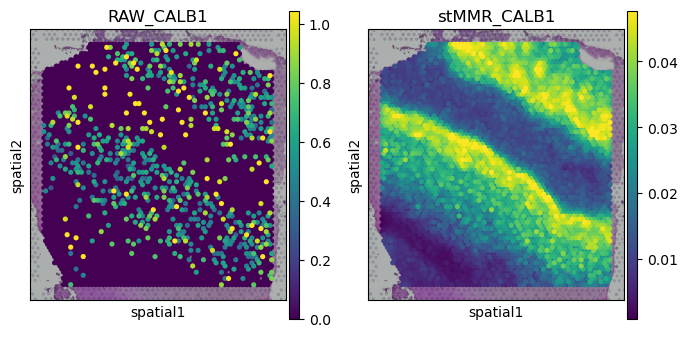

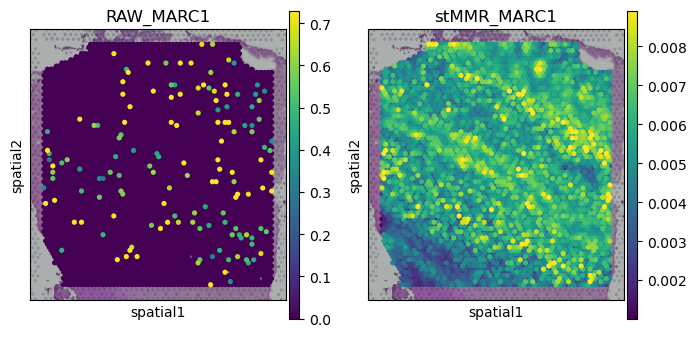

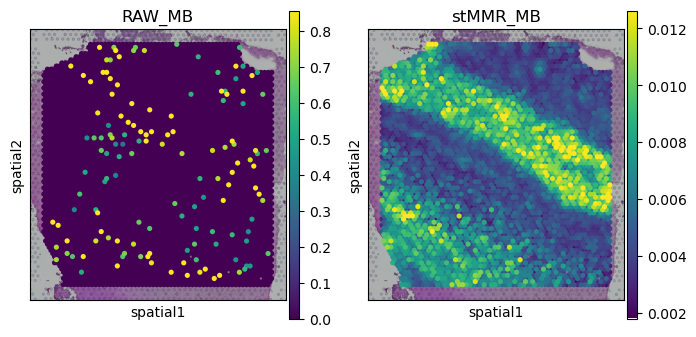

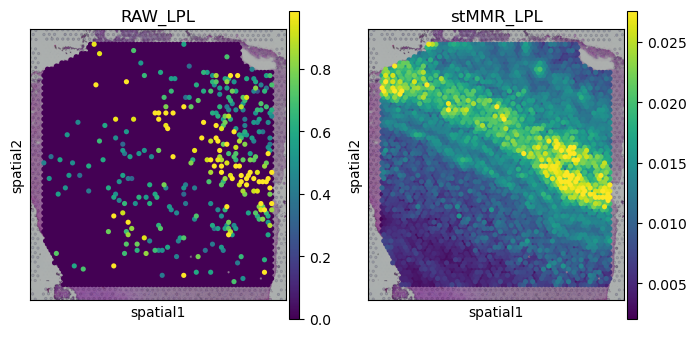

In [ ]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['stMMR'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' % ARI)

genelist=["ADCYAP1","CACNA2D2","CALB1","MARC1","MB","LPL"]
for plot_gene in genelist:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    sc.pl.spatial(adata,spot_size=200, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
    sc.pl.spatial(adata,spot_size=200, img_key="hires", color=plot_gene, show=True, ax=axs[1], title='stMMR_'+plot_gene, layer='stMMR', vmax='p99')